# Lidando com os pedidos duplicados
- Sem poder conversar com Stakeholders, acredito que a melhor forma de lidar com essa situação e ter um cenário conservador é idealmente melhor considerar a nota mais baixa dada pelo cliente.

In [1]:
# Importando as bibliotecas
import sqlite3
import pandas as pd
# Importando minha função consulta
import funcao_auxiliar as af

In [2]:
# Criando uma conexão
con = sqlite3.connect('../dados/vendas_db.db')
cur = con.cursor()

In [3]:
# Fazendo a consulta com as colunas filtradas, já excluindo sem review  
avaliacao_ordem = af.executa_consulta(cur,'SELECT \
                                     o.order_id \
                                    ,o.order_purchase_timestamp \
                                    ,o.order_delivered_customer_date \
                                    ,o.order_estimated_delivery_date \
                                    ,ROUND(MIN(ore.review_score),1) as review_min \
                                   FROM orders o \
                                   LEFT JOIN order_reviews ore \
                                   ON o.order_id = ore.order_id \
                                   WHERE ore.review_score IS NOT NULL \
                                   GROUP BY \
                                     o.order_id \
                                    ,o.order_purchase_timestamp \
                                    ,o.order_delivered_customer_date \
                                    ,o.order_estimated_delivery_date')

(98673, 5)


,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_min
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29 00:00:00,5.0
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15 00:00:00,4.0
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,2018-01-22 13:19:16,2018-02-05 00:00:00,5.0


In [4]:
# Convertendo as colunas do tipo string para tipo data
colunas_data = ['order_purchase_timestamp','order_delivered_customer_date', 
                'order_estimated_delivery_date']
for coluna in colunas_data:
    avaliacao_ordem[coluna] = pd.to_datetime(avaliacao_ordem[coluna])

In [5]:
# Ajustando para dias e criando a coluna no meu DF
avaliacao_ordem['dif_estimado_entrega'] = avaliacao_ordem.order_estimated_delivery_date - avaliacao_ordem.order_delivered_customer_date
avaliacao_ordem['dif_estimado_entrega'] = avaliacao_ordem['dif_estimado_entrega'].dt.days
# Marcando entregas que tiveram atraso com uma marcação (flag)
avaliacao_ordem['atraso'] = avaliacao_ordem['dif_estimado_entrega'].apply(lambda x: 1 if x < 0 else 0)
avaliacao_ordem.head()

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_min,dif_estimado_entrega,atraso
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29,5.0,8.0,0
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15,4.0,2.0,0
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,2018-01-22 13:19:16,2018-02-05,5.0,13.0,0
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,2018-08-14 13:32:39,2018-08-20,4.0,5.0,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,2017-03-01 16:42:31,2017-03-17,5.0,15.0,0


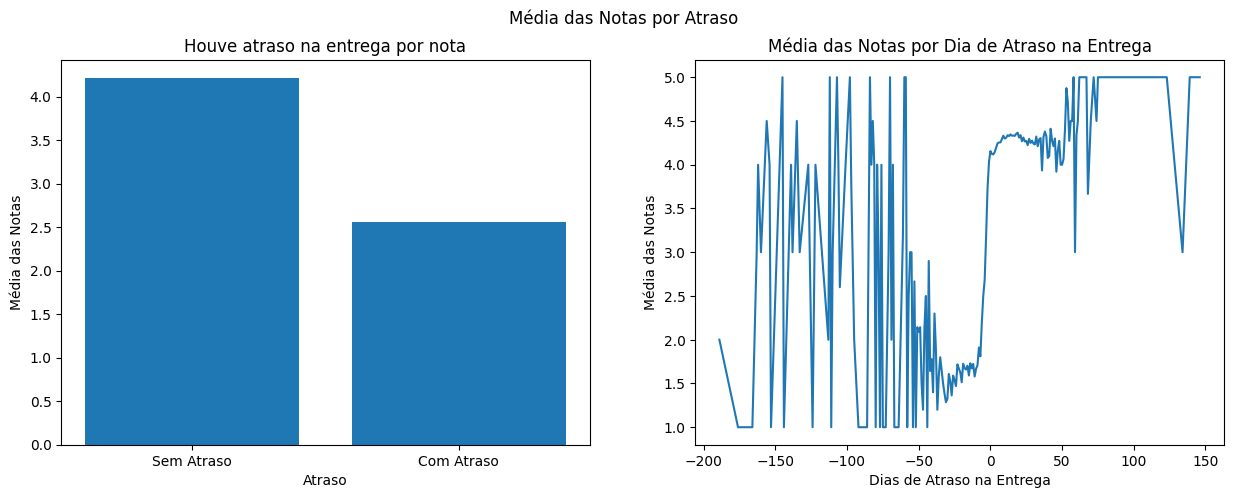

In [6]:
import matplotlib.pyplot as plt

# Agrupando e calculando a média das notas por atraso
media_notas_por_atraso = avaliacao_ordem.groupby('atraso')['review_min'].mean()
media_notas_por_dia_atraso= avaliacao_ordem.groupby('dif_estimado_entrega')['review_min'].mean()

# Criando subplots
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

# Plotando o gráfico de barras
ax[0].bar(media_notas_por_atraso.index, media_notas_por_atraso)

# Plotando o gráfico de linha
media_notas_por_dia_atraso.plot(ax=ax[1])

# Adicionando detalhes aos gráficos
fig.suptitle('Média das Notas por Atraso')
ax[0].set_title('Houve atraso na entrega por nota')
ax[0].set_xlabel('Atraso')
ax[0].set_ylabel('Média das Notas')
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['Sem Atraso', 'Com Atraso'])

ax[1].set_title('Média das Notas por Dia de Atraso na Entrega')
ax[1].set_xlabel('Dias de Atraso na Entrega')
ax[1].set_ylabel('Média das Notas')

# Exibindo os gráficos
plt.show()

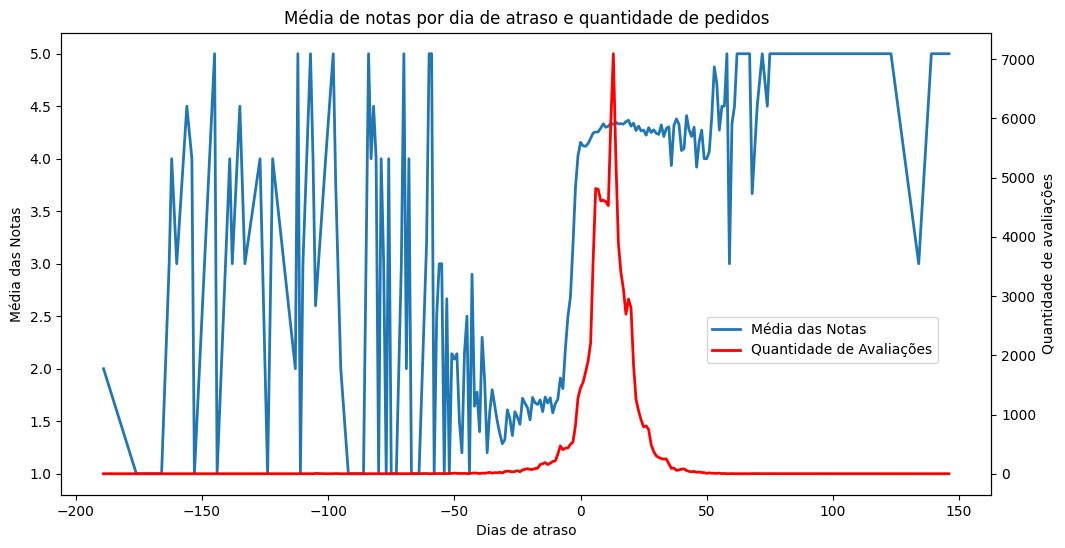

In [7]:
# Melhorando o gráfico e visualizando a quantidade de registros em cada dia
fig, ax = plt.subplots(figsize=(12,6))

base2 = avaliacao_ordem[(avaliacao_ordem.atraso >= -30) & (avaliacao_ordem.atraso <= 50)]

media_notas = base2.groupby('dif_estimado_entrega')['review_min'].mean()
qtd_avaliacoes = base2.groupby('dif_estimado_entrega')['review_min'].count()

ax2 = ax.twinx()

graph= ax.plot(media_notas.index, media_notas.values, linewidth=2.0, label='Média das Notas')
graph2=ax2.plot(qtd_avaliacoes.index, qtd_avaliacoes.values, linewidth=2.0,c='r', label='Quantidade de Avaliações')


ax.set_title('Média de notas por dia de atraso e quantidade de pedidos')
ax.set_ylabel('Média das Notas')
ax2.set_ylabel('Quantidade de avaliações')
ax.set_xlabel('Dias de atraso')
labels = [l.get_label() for l in graph]
labels2 = [l.get_label() for l in graph2]
ax.legend(graph + graph2, labels + labels2, loc='best', bbox_to_anchor=(0.95, 0.4))


plt.show()

# Considerações
- Conseguimos observar que quando o pedido atrasa, em média, temos uma nota 46% menor quando ele não atrasa
- Quando o pedido chega antes do prazo, ele tende a ter notas melhores (acima de 3)
### Agruparei por grupos para tentar melhorar a visualização

In [8]:
# Agrupar os atrasos
def agrupa_atraso(atraso):
    if atraso <= -30:
        return '01. Abaixo de 30 dias'
    elif atraso <= -20:
        return '02. Entre 30 e 20 dias'
    elif atraso <= -10:
        return '03. Entre 20 e 10 dias de atraso'
    else:
        return 'Sem atraso'

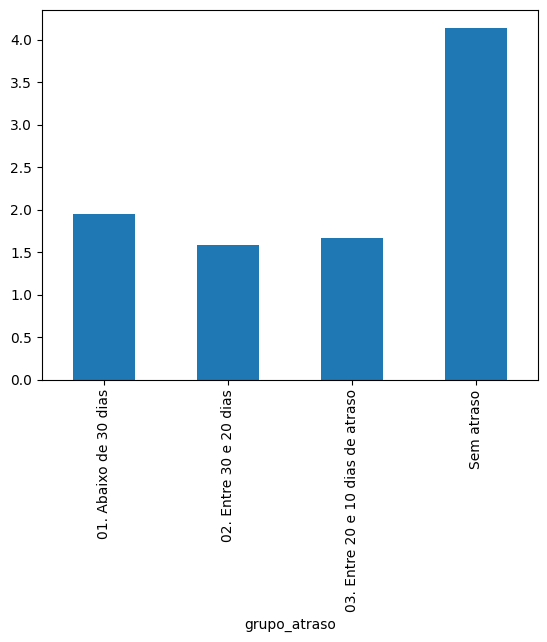

In [9]:
# Aplicando a função
avaliacao_ordem['grupo_atraso'] = avaliacao_ordem.dif_estimado_entrega.apply(agrupa_atraso)
# Verificando a média das notas por faixa de atraso
avaliacao_ordem.groupby('grupo_atraso')['review_min'].mean().plot.bar();

- Percebemos quma diferença ainda maior, então irei espaçar mais

In [10]:
# Usando a função já pronta apenas para adiantar a escrita do código
def agrupa_atraso(atraso):
    if atraso < -20:
        return '01. Mais de 20 dias de atraso'
    elif atraso < -15:
        return '02. Entre 15 e 20 dias de atraso'
    elif atraso < -10:
        return '03. Entre 10 e 15 dias de atraso'
    elif atraso < -8:
        return '04. Entre 8 e 10 dias de atraso'
    elif atraso < -6:
        return '05. Entre 6 e 8 dias de atraso'
    elif atraso < -4:
        return '06. Entre 4 e 6 dias de atraso'
    elif atraso < -2:
        return '07. Entre 2 e 4 dias de atraso'
    elif atraso < 0:
        return '08. Entre 1 e 2 dias de atraso'
    elif atraso == 0:
        return '09. Entregue na data'
    elif atraso <= 2:
        return '10. Entre 0 e 2 dias antes do prazo'
    elif atraso <= 4:
        return '11. Entre 2 e 4 dias antes do prazo'
    elif atraso <= 6:
        return '12. Entre 4 e 6 dias antes do prazo' 
    elif atraso <= 8:
        return '13. Entre 6 e 8 dias antes do prazo' 
    elif atraso <= 10:
        return '14. Entre 8 e 10 dias antes do prazo' 
    elif atraso <= 15:
        return '15. Entre 10 e 15 dias antes do prazo' 
    elif atraso <= 20:
        return '16. Entre 15 e 20 dias antes do prazo' 
    elif atraso <= 30:
        return '17. Entre 20 e 30 dias antes do prazo' 
    elif atraso <= 40:
        return '18. Entre 30 e 40 dias antes do prazo' 
    elif atraso > 40:
        return '19. Mais de 40 dias antes do prazo' 
    else:
        return '20. Verificar'

In [11]:
# Aplicando nova função
avaliacao_ordem['grupo_atraso'] = avaliacao_ordem.dif_estimado_entrega.apply(agrupa_atraso)
avaliacao_ordem.head(3)

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_min,dif_estimado_entrega,atraso,grupo_atraso
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29,5.0,8.0,0,13. Entre 6 e 8 dias antes do prazo
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15,4.0,2.0,0,10. Entre 0 e 2 dias antes do prazo
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,2018-01-22 13:19:16,2018-02-05,5.0,13.0,0,15. Entre 10 e 15 dias antes do prazo


In [12]:
# Verificando as avaliações que não conseguimos analisar a data
avaliacao_ordem[avaliacao_ordem.grupo_atraso == '20. Verificar']

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_min,dif_estimado_entrega,atraso,grupo_atraso
24,0010dedd556712d7bb69a19cb7bbd37a,2017-10-21 19:32:06,NaT,2017-11-03,1.0,NaN,0,20. Verificar
72,002f19a65a2ddd70a090297872e6d64e,2018-03-21 13:05:30,NaT,2018-04-16,3.0,NaN,0,20. Verificar
76,00310b0c75bb13015ec4d82d341865a4,2018-08-15 14:29:08,NaT,2018-08-29,1.0,NaN,0,20. Verificar
227,00a500bc03bc4ec968e574c2553bed4b,2017-11-23 10:53:01,NaT,2018-01-08,2.0,NaN,0,20. Verificar
233,00a99c50fdff7e36262caba33821875a,2018-08-17 16:25:04,NaT,2018-09-18,5.0,NaN,0,20. Verificar
...,...,...,...,...,...,...,...,...
98324,ff0768e3356919b32e3d7f30baecfcfb,2018-04-04 22:58:39,NaT,2018-04-23,1.0,NaN,0,20. Verificar
98396,ff358345576214cc9e08488188973c84,2018-03-03 17:05:12,NaT,2018-04-02,1.0,NaN,0,20. Verificar
98437,ff536d93ae4214b4d51c2894ccfc569f,2017-12-21 09:01:00,NaT,2018-01-10,3.0,NaN,0,20. Verificar
98471,ff7140ba310a4717112d39c0cd0b4062,2017-05-19 18:11:21,NaT,2017-06-26,1.0,NaN,0,20. Verificar


- Acima temos 2843 produtos que não foram entregues ao cliente, como eles não foram entregues irei desconsiderar para o gráfico a seguir.

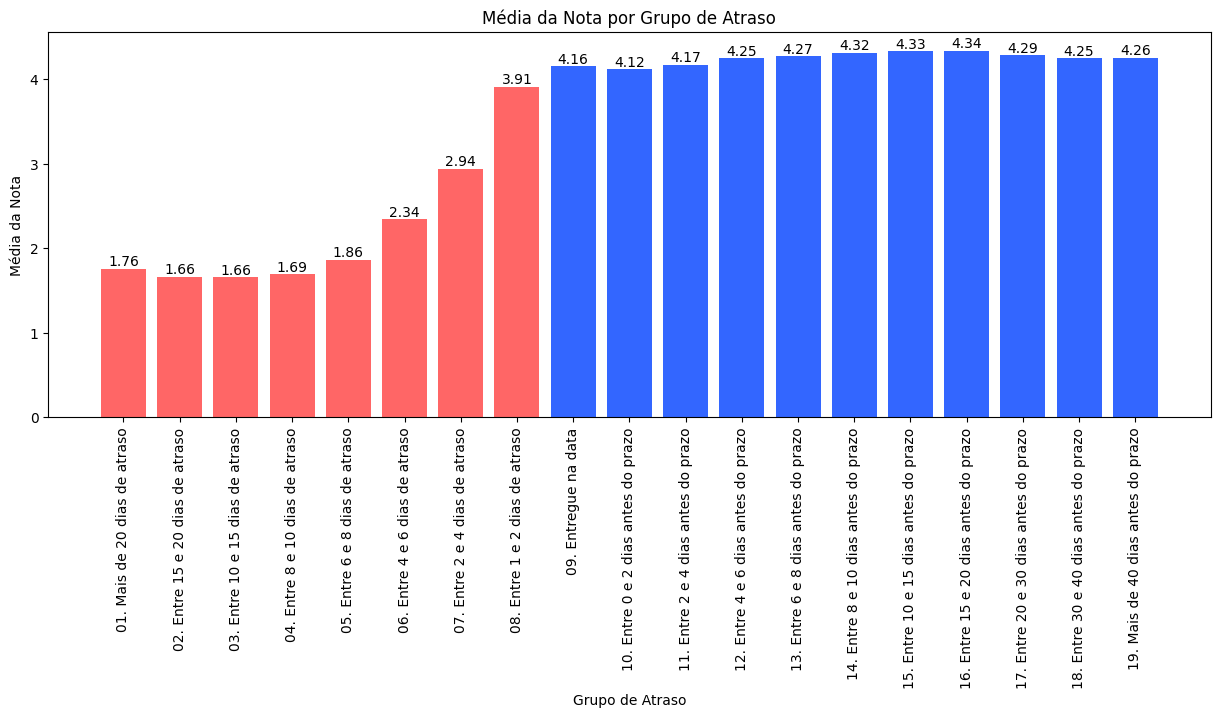

In [13]:
# Podemos retirar da base as linhas que não são do nosso interesse
avaliacao_ordem = avaliacao_ordem[avaliacao_ordem.grupo_atraso != '20. Verificar']
media_notas_por_grupo = avaliacao_ordem.groupby('grupo_atraso')['review_min'].mean()
plt.figure(figsize=(15, 5))


cores = ['#FF6666' if grupo < '09. Entregue na data' else '#3366FF' for grupo in media_notas_por_grupo.index]

plt.bar(media_notas_por_grupo.index, media_notas_por_grupo,color=cores)

for i, media in enumerate(media_notas_por_grupo):
    plt.text(i, media, round(media, 2), ha='center', va='bottom')
plt.xlabel('Grupo de Atraso')
plt.ylabel('Média da Nota')
plt.title('Média da Nota por Grupo de Atraso')

plt.xticks(rotation=90)

# Exibindo o gráfico
plt.show()

# Como saber se as reclamações e notas baixas são realmente por causa do atraso?
- Para verificar isso, farei um novo DF diminuindo a base apenas para clientes que tiveram esse atraso menor que 10 dias

In [14]:
#Criando a base
base_nova = avaliacao_ordem[(avaliacao_ordem.dif_estimado_entrega >= -10) & (avaliacao_ordem.dif_estimado_entrega <= -1)]
base_nova.head(3)

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_min,dif_estimado_entrega,atraso,grupo_atraso
8,0005a1a1728c9d785b8e2b08b904576c,2018-03-19 18:40:33,2018-03-29 18:17:31,2018-03-29,1.0,-1.0,1,08. Entre 1 e 2 dias de atraso
11,00063b381e2406b52ad429470734ebd5,2018-07-27 17:21:27,2018-08-07 13:56:52,2018-08-07,5.0,-1.0,1,08. Entre 1 e 2 dias de atraso
20,000e906b789b55f64edcb1f84030f90d,2017-11-21 18:54:23,2017-12-09 17:27:23,2017-12-07,3.0,-3.0,1,07. Entre 2 e 4 dias de atraso


In [15]:
# Importando a base order_reviews para validar as informçaões dos comentarios
avaliacoes = af.executa_consulta(cur,'SELECT * FROM order_reviews')

(99224, 7)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24


In [16]:
# Usando a nuvem de palavras
from wordcloud import WordCloud

In [17]:
# Transformando todos os comentários em um único texto
texto = ''
for i in avaliacoes.loc[avaliacoes.order_id.isin(base_nova.order_id),'review_comment_message']:
    if i:
        texto += i
        texto += ' '

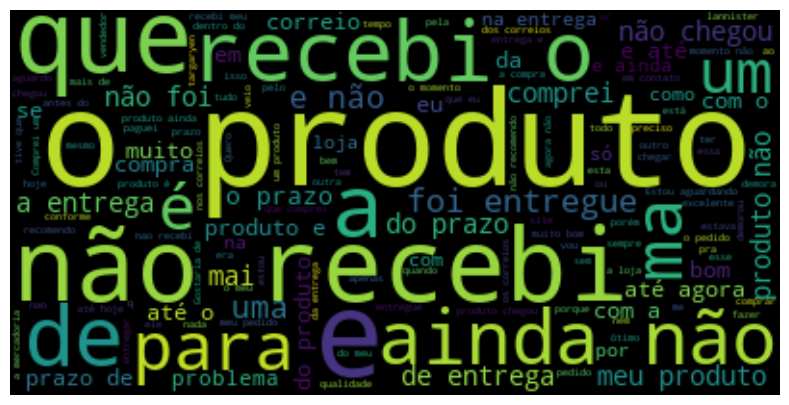

In [18]:
# Gerando a nuvem de palavras
excluir_palavras = ['dia','pois','já','no']
wordcloud = WordCloud(stopwords=excluir_palavras).generate(texto)
# Exibindo a imagem
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()